In [1]:
!pip install -q --upgrade keras-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 22.3 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.20.0 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
import keras
import keras_hub

import tensorflow.strings as tf_strings
import tensorflow.data as tf_data

2025-05-10 16:25:59.407140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746894359.674335      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746894359.745320      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
data_params = {
    "BATCH_SIZE" : 10,
    "SEQ_LEN" : 128
}

In [5]:
model_params = {
    "EMBED_DIM" : 256,
    "FF_DIM" : 128,
    "N_HEADS" : 3,
    "N_LAYERS" : 2,
    "VOCAB_SIZE" : 3330
}

In [6]:
df = pd.read_csv('/kaggle/input/taylorswiftlyrics/taylor_swift_lyrics.csv')
df.dropna(inplace=True)
df.head()

,Song,Lyrics
0,"""Slut!"" (Taylor's Version) (From The Vault)","[Verse 1]\nFlamingo pink, Sunrise Boulevard\nC..."
1,22 (Taylor's Version),[Verse 1]\nIt feels like a perfect night\nTo d...
2,A Perfectly Good Heart,[Chorus]\nWhy would you wanna break\nA perfect...
3,A Place in this World,"[Verse 1]\nI don't know what I want, so don't ..."
4,Afterglow,"[Verse 1]\nI blew things out of proportion, no..."


In [7]:
dataset = tf_data.experimental.make_csv_dataset(
    file_pattern = '/kaggle/input/taylorswiftlyrics/taylor_swift_lyrics.csv',
    batch_size = data_params["BATCH_SIZE"],
    label_name = 'Lyrics',
    num_epochs = 1,
    shuffle = True
)

I0000 00:00:1746894373.758316      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746894373.759046      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
features, label = dataset.take(1).get_single_element()
print("Song:", features['Song'].numpy()[0].decode())
print("Lyrics:", label.numpy()[0].decode())

Song: The Best Day (Taylor’s Version)
Lyrics: [Verse 1]
I'm five years old, it's gettin' cold, I've got my big coat on
I hear your laugh and look up smilin' at you, I run and run
Past the pumpkin patch and the tractor rides, look, now the sky is gold
I hug your legs and fall asleep on the way home
[Chorus]
I don't know why all the trees change in the fall
But I know you're not scared of anything at all
Don't know if Snow White's house is near or far away
But I know I had the best day with you today
[Verse 2]
I'm thirteen now and don't know how my friends could be so mean
I come home cryin' and you hold me tight and grab the keys
And we drive and drive until we found a town far enough away
And we talk and window shop 'til I've forgotten all their names
[Chorus]
I don't know who I'm gonna talk to now at school
But I know I'm laughin' on the car ride home with you
Don't know how long it's gonna take to feel okay
But I know I had the best day with you today
[Bridge]
I have an excellent fat

In [9]:
lyrics_only = dataset.map(lambda features, label: label).unbatch()

In [10]:
vocab = keras_hub.tokenizers.compute_word_piece_vocabulary(
    lyrics_only,
    vocabulary_size = model_params["VOCAB_SIZE"],
    lowercase = True,
    reserved_tokens = ["[PAD]", "[UNK]", "[BOS]"]
)

In [11]:
tokenizer = keras_hub.tokenizers.WordPieceTokenizer(
    vocabulary = vocab,
    sequence_length = data_params["SEQ_LEN"],
    lowercase = True
)

In [12]:
start_packer = keras_hub.layers.StartEndPacker(
    sequence_length = data_params["SEQ_LEN"],
    start_value = tokenizer.token_to_id("[BOS]")
)

In [13]:
def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels

In [14]:
train_ds = lyrics_only.map(
    preprocess,
    num_parallel_calls = tf_data.AUTOTUNE
).prefetch(
    tf_data.AUTOTUNE
).batch(data_params["BATCH_SIZE"])

In [15]:
input_layer = keras.layers.Input(shape=(None,), dtype="int32")

embedding_layer = keras_hub.layers.TokenAndPositionEmbedding(
    vocabulary_size = model_params["VOCAB_SIZE"],
    sequence_length = data_params["SEQ_LEN"],
    embedding_dim = model_params["EMBED_DIM"],
    mask_zero = True
)

In [16]:
x = embedding_layer(input_layer)

for _ in range(model_params["N_LAYERS"]):
    decoder_layer = keras_hub.layers.TransformerDecoder(
        num_heads = model_params["N_HEADS"],
        intermediate_dim = model_params["FF_DIM"]
    )
    x = decoder_layer(x)

In [17]:
outputs = keras.layers.Dense(model_params["VOCAB_SIZE"])(x)

In [18]:
model = keras.Model(inputs=input_layer, outputs=outputs, name="SwiftGPT-v1")

In [19]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_hub.metrics.Perplexity(from_logits=True, mask_token_id=0)

In [20]:
model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])

In [21]:
model.summary()

Model: "SwiftGPT-v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 256)           │         885,248 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder                  │ (None, None, 256)           │         329,085 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_1                │ (None, None, 256)           │         329,085 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 3330)          │         855,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,399,228 (9.15 MB)

 Trainable params: 2,399,228 (9.15 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
 history = model.fit(
     train_ds.skip(4),
     validation_data = train_ds.take(4),
     epochs = 20
 )

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.

     15/Unknown 13s 12ms/step - loss: 7.3007 - perplexity: 1681.2959

I0000 00:00:1746894394.273463      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1746894396.256938      96 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1746894396.261057      96 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - loss: 7.2108 - perplexity: 1564.6552 - val_loss: 5.4510 - val_perplexity: 232.8365
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.3189 - perplexity: 204.4524 - val_loss: 4.8468 - val_perplexity: 127.2061
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.7518 - perplexity: 115.8988 - val_loss: 4.4370 - val_perplexity: 84.5234
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.2684 - perplexity: 71.4125 - val_loss: 4.0714 - val_perplexity: 58.5788
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.9673 - perplexity: 52.8120 - val_loss: 3.6807 - val_perplexity: 39.6748
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.7068 - perplexity: 40.7138 - val_loss: 3.4501 - val_perplexity: 31.4739
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.4898 - perplexity: 32.7811 - val_loss: 3.2581 - val_perplexity: 25.9991
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.3193 - perp

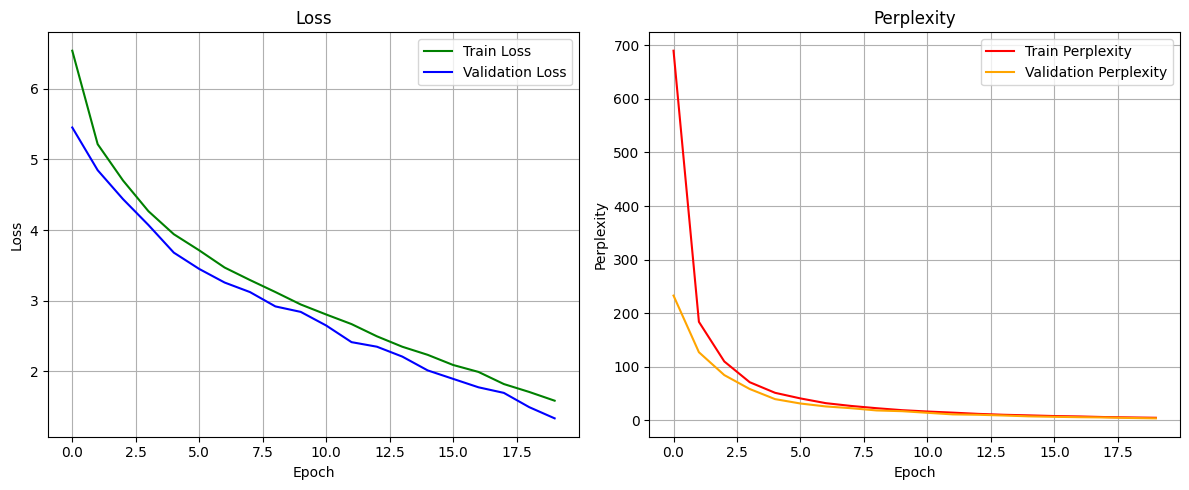

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
axs[0].plot(history.history['loss'], label='Train Loss', color='green')
axs[0].plot(history.history['val_loss'], label='Validation Loss', color='blue')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot Perplexity
axs[1].plot(history.history['perplexity'], label='Train Perplexity', color='red')
axs[1].plot(history.history['val_perplexity'], label='Validation Perplexity', color='orange')
axs[1].set_title('Perplexity')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [24]:
# The "packer" layers adds the [BOS] token for us.
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [25]:
def next(prompt, cache, index):
    logits = model(prompt)[:, index - 1, :]
    # Ignore hidden states for now; only needed for contrastive search
    hidden_states = None
    return logits, hidden_states, cache

In [31]:
sampler = keras_hub.samplers.TopPSampler(
    p = 0.9,
    k = 36,
    temperature = 0.9
    
)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

Top-P search generated text: 
["[BOS] [ verse 1 ] i like this time you forget to you know you were nine i could sit in nothin ' ve got a perfect now i swear that every laugh and told me ( oh , i was a mon ? yeah , i - huh ) i don ' t heard from sls , you stand in rumory faded before i don ' money , you know that i and i could show you said , i love so ( and whot on past , notevitterpy as i never say now you [ verse 2 ] i wonderful , i ' m sitting in time"]

